# Machine Learning Project 
## Titanic Survival Prediction
### Author: Sébastien Lozano Forero


Original competition available [here](https://www.kaggle.com/c/titanic/data)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from IPython.core.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, average_precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, plot_roc_curve, classification_report, plot_confusion_matrix

# Data Imports

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Analysis

In general, ProfileReport would provide an exhaustive descriptive analysis of the data, allowing us to find some useful insights

In [3]:
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Some insights: 
- 11 variables (5 mumerical and 6 Categorical) + survival (target variable)
- 891 individuals
- 8% of the dataset information is missing (specially in age and cabin)
- Variables such as PassengerId and Name are identifiers only
- Variables splitting the data the most: Sex, Pclass and embarked
- Variables sibsp and parch provide information on whether a person was traveling alone or accompanied. 

#### Target variable

0: Did not survive
1: Did survive

In [4]:
aux = df.groupby(['Survived']).count()['PassengerId']
aux

Survived
0    549
1    342
Name: PassengerId, dtype: int64

#### coding Sex as 0s and 1s

In [5]:
df['Sex'] = df['Sex'].map({'male':0, 'female':1}).astype(int)

### Creating the lonely traveller variable

In [6]:
df['AcomTrav'] = df['Parch'] +df['SibSp']

In [7]:
df['AloneTraveler'] = df['AcomTrav'].apply(lambda x: 0 if x>0 else 1 )
df['AloneTraveler']

0      0
1      0
2      1
3      0
4      1
      ..
886    1
887    1
888    0
889    1
890    1
Name: AloneTraveler, Length: 891, dtype: int64

# Missing value imputation

In [8]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,AcomTrav,AloneTraveler
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.904602,0.602694
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,1.613459,0.489615
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,10.000000,1.000000


Variables such as cabin and age do have some missing values. Cabin refers to the Cabin number each passenger were assigned and it is lacking ~80% of the values. Age is missing ~20% of the values. As is reasonably to believe that age would be more important to predict survival than the cabin number, we will focus only on age. 

We will use the median value of Age to input missing values in Age. 

In [9]:
median = df['Age'].median()
df['Age'] = df['Age'].fillna(median)

In [10]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,AcomTrav,AloneTraveler
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.361582,0.523008,0.381594,32.204208,0.904602,0.602694
std,257.353842,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,1.613459,0.489615
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,10.000000,1.000000


This procedure barely affected the variability of the variable age. This is a good sign 

# Some Hipothesis 

### H1. Females were more likely to survive

Survived  Sex
0         0      468
          1       81
1         0      109
          1      233
Name: PassengerId, dtype: int64


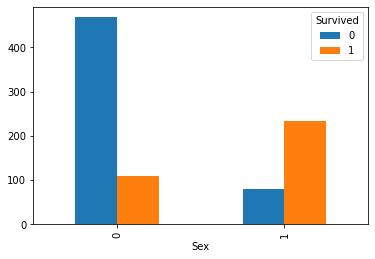

In [11]:
grouped_sex = df.groupby(['Survived','Sex']).count()['PassengerId']
print(grouped_sex)
(grouped_sex.unstack(level=0).plot.bar())
plt.show()

Indeed, women were more likely to survive. Out of every four survivors, three were women

### H2. People paying higher fares were more likely to survive

There are two approaches for this:

    i. Using a discrete version of Fare variable
    ii. Using the Pclass variable

<AxesSubplot:xlabel='Fare', ylabel='Count'>

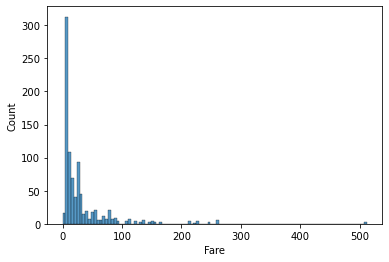

In [12]:
sns.histplot(x = df['Fare'])

In [13]:
bins = [0,10,30,50,100,200]
group_names = [1,2,3,4,5]
df['FareGroup'] = pd.cut(df['Fare'], bins, labels=group_names)

FareGroup  Survived
1          0           255
           1            66
2          0           182
           1           139
3          0            47
           1            27
4          0            37
           1            70
5          0             8
           1            25
Name: PassengerId, dtype: int64


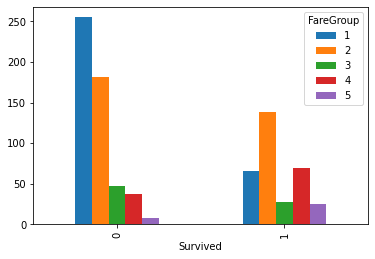

In [14]:
grouped_fare = df.groupby(['FareGroup','Survived']).count()['PassengerId']
print(grouped_fare)
(grouped_fare.unstack(level=0).plot.bar())
plt.show()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: PassengerId, dtype: int64


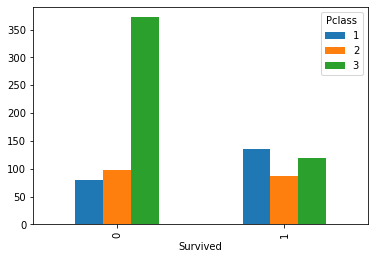

In [15]:
grouped_class = df.groupby(['Pclass','Survived']).count()['PassengerId']
print(grouped_class)
(grouped_class.unstack(level=0).plot.bar())
plt.show()

Indeed, People who boarded the ship with low fares tickets, were more likely to not survive. Specially, for third class passengers

### H3. Passengers traveling alone were less likely to survive

Survived  AloneTraveler
0         0                175
          1                374
1         0                179
          1                163
Name: PassengerId, dtype: int64


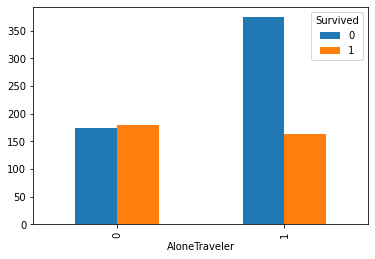

In [16]:
grouped_trav= df.groupby(['Survived','AloneTraveler']).count()['PassengerId']
print(grouped_trav)
(grouped_trav.unstack(level=0).plot.bar())
plt.show()

Lonely travelers were less likely to survive. 

## H4. There is some relation between Class and embarking port

AxesSubplot(0.125,0.125;0.775x0.755)


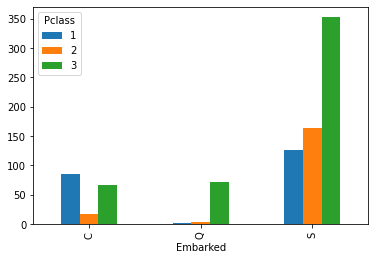

In [17]:
print(df.groupby(['Pclass', 'Embarked'])
        .count()['PassengerId']
        .unstack(level=0)
        .plot.bar())

There is no clear relation between Class and embarking port

# Machine Learning Models

In [18]:
def conf_mat_acc(modelo):
  disp = plot_confusion_matrix(modelo, X_train, y_train,
                        cmap=plt.cm.Blues, values_format="d")
  true_pred = disp.confusion_matrix[0,0]+disp.confusion_matrix[1,1]
  total_data = np.sum(disp.confusion_matrix)
  accuracy = true_pred/total_data
  print('accuracy: ', np.round(accuracy, 2))
  plt.show()

In [19]:
X = df[['Pclass','Sex','Age','AloneTraveler']]
y = df['Survived']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
print("X_train shape is:", X_train.shape)
print("X_test shape is:", X_test.shape)
print("y_train shape is:", y_train.shape)
print("y_test shape is:", y_test.shape)

X_train shape is: (623, 4)
X_test shape is: (268, 4)
y_train shape is: (623,)
y_test shape is: (268,)


## Logistic Regression

In [22]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

accuracy:  0.79


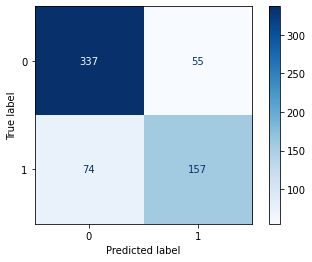

In [23]:
conf_mat_acc(logreg)

In [24]:
logreg_predictions = logreg.predict(X_test)

In [25]:
test_accuracy = accuracy_score(y_test, logreg_predictions)
print('Model accuracy: {0:0.4f}'. format(test_accuracy))
test_precision = average_precision_score(y_test, logreg_predictions)
print('Model Presicion: {0:0.4f}'. format(test_precision))
test_recall = f1_score(y_test, logreg_predictions)
print('Model F1 : {0:0.4f}'. format(test_recall))
test_f1 =recall_score(y_test, logreg_predictions)
print('Model Recall : {0:0.4f}'. format(test_f1))
test_roc_auc = roc_auc_score(y_test, logreg_predictions)
print('Model ROC : {0:0.4f}'. format(test_roc_auc))

Model accuracy: 0.8097
Model Presicion: 0.6931
Model F1 : 0.7560
Model Recall : 0.7117
Model ROC : 0.7953


In [26]:
logreg_output = []

In [27]:
for i in [test_accuracy,test_precision,test_recall,test_f1,test_roc_auc]:
  logreg_output.append(i)

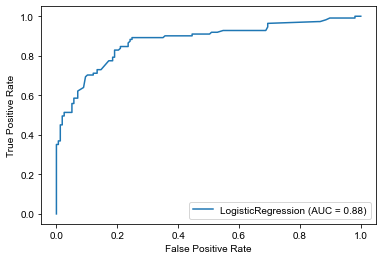

In [28]:
svc_disp = plot_roc_curve(logreg, X_test, y_test)
sns.set(font_scale = 1)
plt.show()

## XGBRegressor

In [29]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

accuracy:  0.88


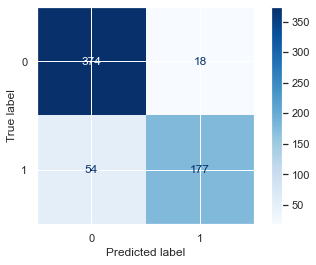

In [30]:
conf_mat_acc(xgb)

In [31]:
xgb_predictions = xgb.predict(X_test)

In [32]:
test_accuracy = accuracy_score(y_test, xgb_predictions)
print('Model accuracy: {0:0.4f}'. format(test_accuracy))
test_precision = average_precision_score(y_test, xgb_predictions)
print('Model Presicion: {0:0.4f}'. format(test_precision))
test_recall = f1_score(y_test, xgb_predictions)
print('Model F1 : {0:0.4f}'. format(test_recall))
test_f1 =recall_score(y_test, xgb_predictions)
print('Model Recall : {0:0.4f}'. format(test_f1))
test_roc_auc = roc_auc_score(y_test, xgb_predictions)
print('Model ROC : {0:0.4f}'. format(test_roc_auc))

Model accuracy: 0.7948
Model Presicion: 0.6752
Model F1 : 0.7264
Model Recall : 0.6577
Model ROC : 0.7747


In [33]:
xgb_output = []

In [34]:
for i in [test_accuracy,test_precision,test_recall,test_f1,test_roc_auc]:
  xgb_output.append(i)

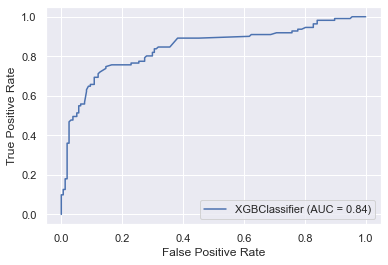

In [35]:
svc_disp = plot_roc_curve(xgb, X_test, y_test)
sns.set(font_scale = 1)
plt.show()

## Random Forest Regressor

In [36]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

accuracy:  0.9


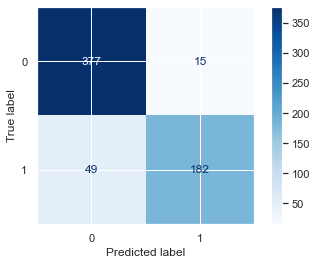

In [37]:
conf_mat_acc(rf)

In [38]:
rf_predictions = rf.predict(X_test)

In [39]:
test_accuracy = accuracy_score(y_test, rf_predictions)
print('Model accuracy: {0:0.4f}'. format(test_accuracy))
test_precision = average_precision_score(y_test, rf_predictions)
print('Model Presicion: {0:0.4f}'. format(test_precision))
test_recall = f1_score(y_test, rf_predictions)
print('Model F1 : {0:0.4f}'. format(test_recall))
test_f1 =recall_score(y_test, rf_predictions)
print('Model Recall : {0:0.4f}'. format(test_f1))
test_roc_auc = roc_auc_score(y_test, rf_predictions)
print('Model ROC : {0:0.4f}'. format(test_roc_auc))

Model accuracy: 0.8097
Model Presicion: 0.6941
Model F1 : 0.7536
Model Recall : 0.7027
Model ROC : 0.7940


In [40]:
rf_output = []

In [41]:
for i in [test_accuracy,test_precision,test_recall,test_f1,test_roc_auc]:
  rf_output.append(i)

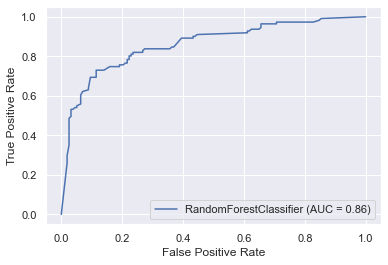

In [42]:
svc_disp = plot_roc_curve(rf, X_test, y_test)
sns.set(font_scale = 1)
plt.show()

## Desicion Tree 

In [43]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

accuracy:  0.9


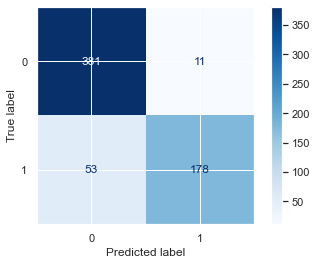

In [44]:
conf_mat_acc(dt)

In [45]:
dt_predictions = dt.predict(X_test)

In [46]:
test_accuracy = accuracy_score(y_test, dt_predictions)
print('Model accuracy: {0:0.4f}'. format(test_accuracy))
test_precision = average_precision_score(y_test, dt_predictions)
print('Model Presicion: {0:0.4f}'. format(test_precision))
test_recall = f1_score(y_test, dt_predictions)
print('Model F1 : {0:0.4f}'. format(test_recall))
test_f1 =recall_score(y_test, dt_predictions)
print('Model Recall : {0:0.4f}'. format(test_f1))
test_roc_auc = roc_auc_score(y_test, dt_predictions)
print('Model ROC : {0:0.4f}'. format(test_roc_auc))

Model accuracy: 0.7612
Model Presicion: 0.6273
Model F1 : 0.6893
Model Recall : 0.6396
Model ROC : 0.7434


In [47]:
dt_output = []

In [48]:
for i in [test_accuracy,test_precision,test_recall,test_f1,test_roc_auc]:
  dt_output.append(i)

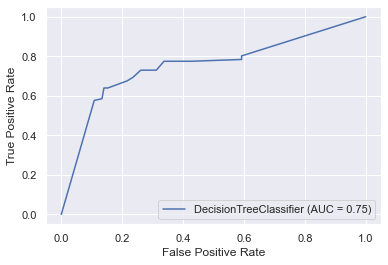

In [49]:
svc_disp = plot_roc_curve(dt, X_test, y_test)
sns.set(font_scale = 1)
plt.show()

## Support Vector Machine (SVM)

In [50]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

accuracy:  0.65


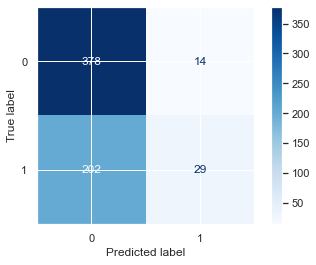

In [51]:
conf_mat_acc(svm)

In [52]:
svm_predictions = svm.predict(X_test)

In [53]:
test_accuracy = accuracy_score(y_test, svm_predictions)
print('Model accuracy: {0:0.4f}'. format(test_accuracy))
test_precision = average_precision_score(y_test, svm_predictions)
print('Model Presicion: {0:0.4f}'. format(test_precision))
test_recall = f1_score(y_test, svm_predictions)
print('Model F1 : {0:0.4f}'. format(test_recall))
test_f1 =recall_score(y_test, svm_predictions)
print('Model Recall : {0:0.4f}'. format(test_f1))
test_roc_auc = roc_auc_score(y_test, svm_predictions)
print('Model ROC : {0:0.4f}'. format(test_roc_auc))

Model accuracy: 0.6007
Model Presicion: 0.4322
Model F1 : 0.1157
Model Recall : 0.0631
Model ROC : 0.5220


In [54]:
svm_output = []

In [55]:
for i in [test_accuracy,test_precision,test_recall,test_f1,test_roc_auc]:
  svm_output.append(i)

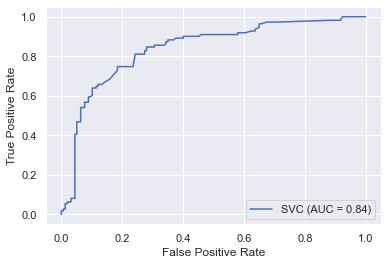

In [56]:
svc_disp = plot_roc_curve(svm, X_test, y_test)
sns.set(font_scale = 1)
plt.show()

## Naive Bayes

In [57]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

accuracy:  0.78


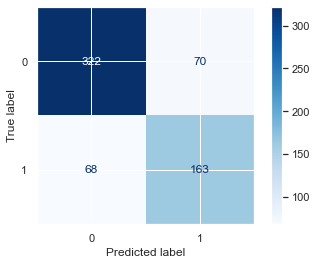

In [58]:
conf_mat_acc(nb)

In [59]:
nb_predictions = nb.predict(X_test)

In [60]:
test_accuracy = accuracy_score(y_test, nb_predictions)
print('Model accuracy: {0:0.4f}'. format(test_accuracy))
test_precision = average_precision_score(y_test, nb_predictions)
print('Model Presicion: {0:0.4f}'. format(test_precision))
test_recall = f1_score(y_test, nb_predictions)
print('Model F1 : {0:0.4f}'. format(test_recall))
test_f1 =recall_score(y_test, nb_predictions)
print('Model Recall : {0:0.4f}'. format(test_f1))
test_roc_auc = roc_auc_score(y_test, nb_predictions)
print('Model ROC : {0:0.4f}'. format(test_roc_auc))

Model accuracy: 0.7873
Model Presicion: 0.6584
Model F1 : 0.7467
Model Recall : 0.7568
Model ROC : 0.7828


In [61]:
nb_output = []

In [62]:
for i in [test_accuracy,test_precision,test_recall,test_f1,test_roc_auc]:
  nb_output.append(i)

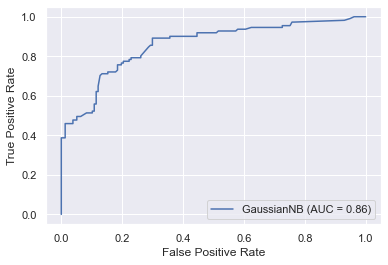

In [63]:
svc_disp = plot_roc_curve(nb, X_test, y_test)
sns.set(font_scale = 1)
plt.show()

# Assesment

In [64]:
metrics = (pd.DataFrame([logreg_output,xgb_output,rf_output,dt_output,svm_output,nb_output],
                        index=['Logistic Regression','XG Boost','Random Forest','Decision Tree','SVM','Naive Bayes'],
                        columns=['Accuracy','Precision','Recall','F1 Score','AUROC'])*100).round(2)

metrics

,Accuracy,Precision,Recall,F1 Score,AUROC
Logistic Regression,80.97,69.31,75.60,71.17,79.53
XG Boost,79.48,67.52,72.64,65.77,77.47
Random Forest,80.97,69.41,75.36,70.27,79.40
Decision Tree,76.12,62.73,68.93,63.96,74.34
SVM,60.07,43.22,11.57,6.31,52.20
Naive Bayes,78.73,65.84,74.67,75.68,78.28


# Forecasting

In [65]:
df_test = pd.read_csv('test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing 

In [66]:
df_test['Sex'] = df_test['Sex'].map({'male':0, 'female':1}).astype(int)
df_test['AcomTrav'] = df_test['Parch'] +df_test['SibSp']
df_test['AloneTraveler'] = df_test['AcomTrav'].apply(lambda x: 0 if x>0 else 1 )
df_test['Age'] = df_test['Age'].fillna(median)

In [67]:
X_test = df_test[['Pclass','Sex','Age','AloneTraveler']]
X_test

,Pclass,Sex,Age,AloneTraveler
0,3,0,34.5,1
1,3,1,47.0,0
2,2,0,62.0,1
3,3,0,27.0,1
4,3,1,22.0,0
...,...,...,...,...
413,3,0,28.0,1
414,1,1,39.0,1
415,3,0,38.5,1
416,3,0,28.0,1


In [68]:
logreg_predictions = pd.Series(logreg.predict(X_test))
xgb_predictions = pd.Series(xgb.predict(X_test))
rf_predictions = pd.Series(rf.predict(X_test))
dt_predictions = pd.Series(dt.predict(X_test))
svm_predictions = pd.Series(svm.predict(X_test))
nb_predictions = pd.Series(nb.predict(X_test))

In [69]:
names = ['SLF_Logistic_Regression','SLF_XGBoost','SLF_Random_Forest','SLF_Decision_Tree','SLF_SVM','SLF_Naive_Bayes']
models = [logreg_predictions,xgb_predictions,rf_predictions,dt_predictions,svm_predictions,nb_predictions]

for i in range(6): 
    output = pd.DataFrame({'PassengerId':df_test['PassengerId'],
                'Survived':models[i]})
    output.to_csv(names[i]+'.csv', index=False)

In [70]:
forecast = {'Passenger ID':df_test['PassengerId'],
            'Logistic Regression':logreg_predictions,
            'XG Boost':xgb_predictions,
            'Random Forest':rf_predictions,
            'Decision Tree':dt_predictions,
            'SVM':svm_predictions,
            'Naive Bayes':nb_predictions}
forecast = pd.DataFrame(forecast)
forecast

,Passenger ID,Logistic Regression,XG Boost,Random Forest,Decision Tree,SVM,Naive Bayes
0,892,0,0,0,0,0,0
1,893,0,0,0,0,0,1
2,894,0,0,1,1,0,0
3,895,0,1,1,1,0,0
4,896,1,1,0,0,0,1
...,...,...,...,...,...,...,...
413,1305,0,0,0,0,0,0
414,1306,1,1,1,1,0,1
415,1307,0,0,0,0,0,0
416,1308,0,0,0,0,0,0


# Kaggle Results

![Kaggle Results](img/kaggle.png)